In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_5324.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_3382.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_1398.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_1142.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_5002.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_2646.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_3476.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_1613.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_5593.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_2975.BMP
/kaggle/input/finger-print-based-blood-g

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
import numpy as np
import os
import shutil
from sklearn.utils import resample
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
dataset_path = "/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group"

In [4]:
BATCH_SIZE = 32

In [5]:
# Step 1: Load dataset
dataset = image_dataset_from_directory(
    dataset_path,
    labels="inferred",
    label_mode="int",
    image_size=(64, 64),  # Resize images to a standard size
    batch_size=BATCH_SIZE,
    shuffle=True
)

Found 6000 files belonging to 8 classes.


In [6]:
# Step 2: Check class distribution
class_names = dataset.class_names
class_counts = Counter()

for _, labels in dataset.unbatch():
  class_counts[int(labels.numpy())] += 1

print("Class Distribution:")
for i, count in class_counts.items():
  print(f"{class_names[i]}: {count}")

Class Distribution:
B+: 652
B-: 741
A-: 1009
AB+: 708
AB-: 761
O+: 852
A+: 565
O-: 712


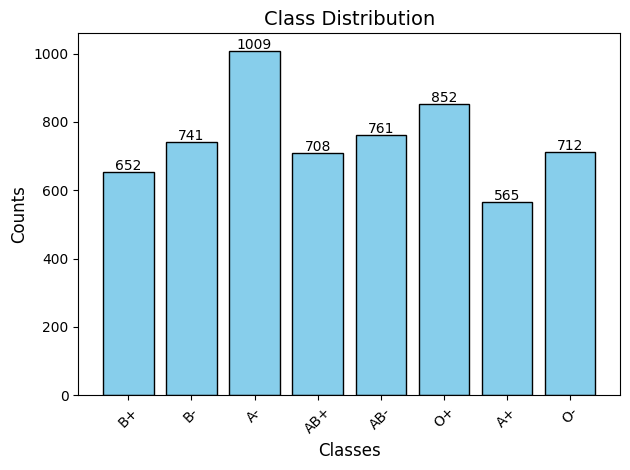

In [7]:
def plot_class_distribution(class_names, class_counts):
    """
    Plots the distribution of classes in the dataset.

    Parameters:
        class_names (list): List of class names.
        class_counts (dict): Dictionary with class indices as keys and counts as values.

    Returns:
        None
    """

    # Extract class names and their corresponding counts
    classes = [class_names[i] for i in class_counts.keys()]
    counts = [class_counts[i] for i in class_counts.keys()]

    bars = plt.bar(classes, counts, color='skyblue', edgecolor='black')

    # Add labels on top of the bars
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 3, 
                 str(count), ha='center', va='bottom', fontsize=10, color='black')
    plt.xlabel('Classes', fontsize=12)
    plt.ylabel('Counts', fontsize=12)
    plt.title('Class Distribution', fontsize=14)
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()



# Assuming class_names and class_counts are already calculated
plot_class_distribution(class_names, class_counts)

In [8]:
max_count = max(class_counts.values())

# Function to oversample a class
def oversample_class(class_id, count, max_count):
  """
  Oversamples a class to match the maximum count of the dataset.

  Args:
    class_id: The ID of the class to oversample.
    count: The current count of the class.
    max_count: The maximum count of any class in the dataset.

  Returns:
    A dataset with the class oversampled to match the maximum count.
  """

  # Ensure the dataset is unbatched for filtering
  unbatched_dataset = dataset.unbatch()

  # Filter the dataset for the specific class
  class_dataset = unbatched_dataset.filter(lambda img, lbl: tf.equal(lbl, class_id))

  # Calculate the number of repetitions needed
  repeat_factor = max_count // count + (max_count % count > 0)

  # Repeat the dataset to match the desired count
  return class_dataset.repeat(repeat_factor).take(max_count)

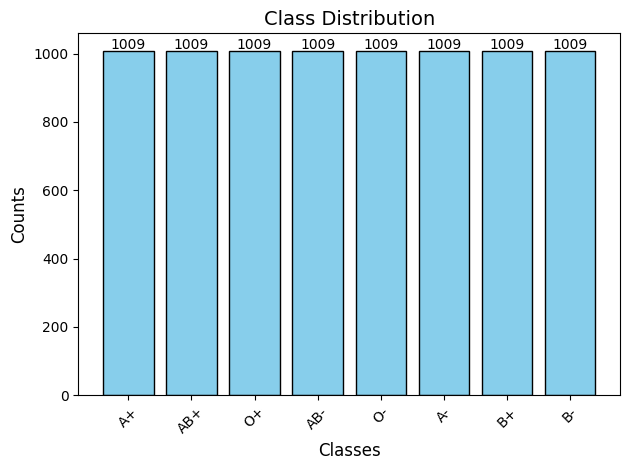

In [9]:
import numpy as np
from collections import Counter
# Step 1: Balance the dataset
balanced_datasets = []
for class_id, count in class_counts.items():
    balanced_datasets.append(oversample_class(class_id, count, max_count))

# Step 2: Combine balanced datasets
balanced_dataset = tf.data.Dataset.sample_from_datasets(balanced_datasets)

# Step 3: Check balanced class distribution
# Step 3: Check balanced class distribution
balanced_class_counts = Counter()

# Iterate through the unbatched dataset
for image, label in balanced_dataset:  # Each element is (image, label)
    balanced_class_counts.update([int(label.numpy())])  # Convert scalar tensor to integer
plot_class_distribution(class_names, balanced_class_counts)



In [10]:
# Step 4: Batch the balanced dataset
balanced_dataset = balanced_dataset.batch(BATCH_SIZE, drop_remainder=True)
for sample in balanced_dataset.take(10):
  print(sample[0].shape)

(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)


In [11]:
balanced_dataset_unbatched = balanced_dataset.unbatch()
dataset_size = sum(1 for _ in balanced_dataset_unbatched)
print(f"Total dataset size: {dataset_size}")

Total dataset size: 8064


In [12]:
# Unbatch the dataset to work at the sample level
balanced_dataset_unbatched = balanced_dataset.unbatch()

# Compute sizes based on dataset size and desired splits
train_ratio=0.7
val_ratio=0.2
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)

# Split the dataset into training, validation, and test
train_dataset = balanced_dataset_unbatched.take(train_size)
val_test_dataset = balanced_dataset_unbatched.skip(train_size)
val_dataset = val_test_dataset.take(val_size)
test_dataset = val_test_dataset.skip(val_size)

# Rebatch the datasets after splitting
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

# Check the number of batches in each dataset
train_batch_count = sum(1 for _ in train_dataset)
val_batch_count = sum(1 for _ in val_dataset)
test_batch_count = sum(1 for _ in test_dataset)

# Extract features and labels for training and validation
def preprocess_dataset(dataset):
    features, labels = [], []
    for batch in dataset:
        x, y = batch
        features.append(x)
        labels.append(y)
    return tf.concat(features, axis=0), tf.concat(labels, axis=0)

x_train, y_train = preprocess_dataset(train_dataset)
x_val, y_val = preprocess_dataset(val_dataset)

print(f"Training dataset size: {(train_batch_count * BATCH_SIZE)}")
print(f"Validation dataset size: {(val_batch_count * BATCH_SIZE)}")
print(f"Testing dataset size: {(test_batch_count * BATCH_SIZE)}")

Training dataset size: 5632
Validation dataset size: 1600
Testing dataset size: 800


In [15]:
import tensorflow as tf

def create_high_accuracy_model(input_shape=(64, 64, 3), num_classes=10):
    model = tf.keras.models.Sequential([
        # First Convolutional Block
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3),

        # Second Convolutional Block
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.4),

        # Third Convolutional Block
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.4),

        # Fourth Convolutional Block
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.4),

        # Fifth Convolutional Block
        tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.5),

        # Fully Connected Layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.5),

        # Output Layer
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Example usage:
# Specify the input shape and number of classes
input_shape = (64, 64, 3)  # Example input shape for images
num_classes = len(class_names)  # Number of classes

# Create the model
model = create_high_accuracy_model(input_shape=input_shape, num_classes=num_classes)


In [16]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define ReduceLROnPlateau callback to reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.5,  # Reduce the learning rate by a factor of 0.5
    patience=3,  # Wait for 3 epochs without improvement before reducing LR
    verbose=1,  # Print a message when the learning rate is reduced
    min_lr=1e-6  # Minimum learning rate to avoid too small values
)

# Define EarlyStopping callback to stop training when validation loss doesn't improve
early_stop = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=100,  # Stop after 5 epochs without improvement
    verbose=1,  # Print a message when training is stopped
    restore_best_weights=True  # Restore the model weights from the best epoch
)

In [18]:


# Save checkpoint in Kaggle's working directory
checkpoint = ModelCheckpoint(
    filepath='/kaggle/working/model_checkpoint01.keras',  # Save model here
    monitor='val_loss',                                 # Monitor validation loss
    save_best_only=True,                                # Save the best model only
    save_weights_only=False,                            # Save entire model (architecture + weights)
    verbose=1
)




In [7]:
import os

# Define the checkpoint file path
file_path = '/kaggle/working/model_checkpoint.keras'

# Check if the file exists
if os.path.exists(file_path):
    print("Checkpoint file exists.")
else:
    print("Checkpoint file NOT found. Please check your training code.")


Checkpoint file NOT found. Please check your training code.


In [19]:
# Train the model with the checkpoint
history_high_acc=model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=150,
    callbacks=[reduce_lr, early_stop, checkpoint]  # Add checkpoint callback
)

Epoch 1/150
168/176 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1272 - loss: 35.0027
Epoch 1: val_loss improved from inf to 2.08024, saving model to /kaggle/working/model_checkpoint01.keras
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.1271 - loss: 33.7013 - val_accuracy: 0.1231 - val_loss: 2.0802 - learning_rate: 0.0010
Epoch 2/150
171/176 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1291 - loss: 2.0773
Epoch 2: val_loss improved from 2.08024 to 1.93775, saving model to /kaggle/working/model_checkpoint01.keras
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1304 - loss: 2.0760 - val_accuracy: 0.3562 - val_loss: 1.9377 - learning_rate: 0.0010
Epoch 3/150
169/176 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3440 - loss: 1.7024
Epoch 3: val_loss improved from 1.93775 to 1.65939, saving model to /kaggle/working/model_checkpoint01.keras
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3465 - loss: 1.6970 - val_accuracy: 0.4725 - val_loss: 1.6594 - learning_ra

In [22]:
# Evaluate the model on validation data
high_acc_eval = model.evaluate(x_val, y_val)  # Use the model object to evaluate

print(f"High Accuracy Model: Loss: {high_acc_eval[0]}, Accuracy: {high_acc_eval[1]}")


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9587 - loss: 0.2436
High Accuracy Model: Loss: 0.24280792474746704, Accuracy: 0.9512500166893005


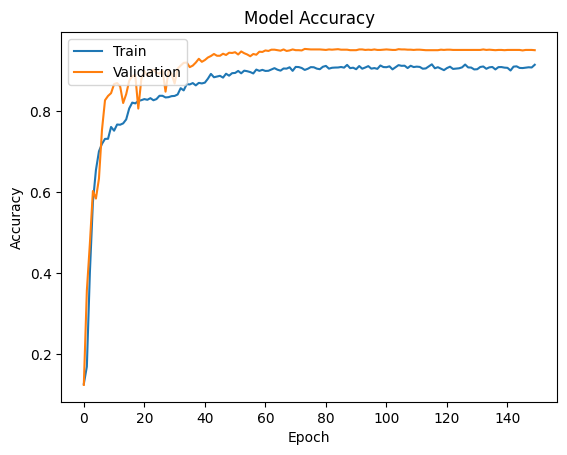

In [23]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])

    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Call the function to display the accuracy graph
plot_accuracy(history_high_acc)

In [24]:

# Initialize lists for true and predicted labels
y_true = []  # True labels
y_pred = []  # Predicted labels

# Iterate over the test dataset and collect the true and predicted labels
for images, labels in test_dataset:
    # Get predictions
    predictions = model.predict(images)  # Use your trained model
    predicted_labels = np.argmax(predictions, axis=1)  # Convert probabilities to class labels

    # Append true and predicted labels
    y_true.extend(labels.numpy())  # Convert tensor to numpy array and append
    y_pred.extend(predicted_labels)  # Append predicted labels

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_names)

print("Classification Report:")
print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Classification Report:
              precision   

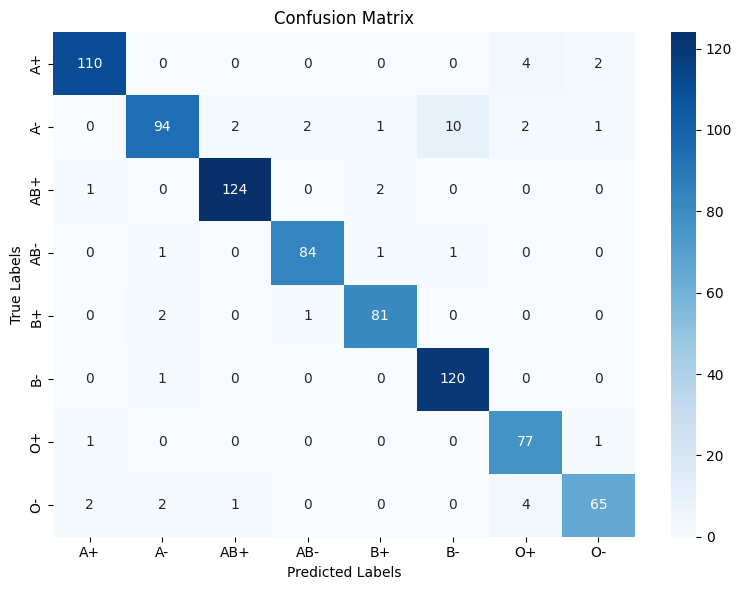

In [25]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()  # Adjust layout to fit labels
plt.show()